# t-SNE visualization of cluster centroid with Nxgraphs metrics

In [3]:
def plot_embedding_unsuper_num_clusters(Z_tsne, y_tsne, num_clusters, title=None, legend=True, withClustersImg=True):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib import offsetbox
    from matplotlib.offsetbox import TextArea, AnnotationBbox
    import matplotlib.gridspec as gridspec
    from matplotlib.patches import ConnectionPatch
    import scipy.spatial as spatial
    from matplotlib._png import read_png
    
    x_min, x_max = np.min(Z_tsne, 0), np.max(Z_tsne, 0)
    Z_tsne = (Z_tsne - x_min) / (x_max - x_min)
    
    # get cluster centroids embedded t-SNE coordinates
    muZ_tsne = Z_tsne[len(y_tsne)-1:-1,:]
    Z_tsne = Z_tsne[0:len(y_tsne),:]
    
    # process labels 
    figTSNE = plt.figure(figsize=(32, 24))
    numclusters_plot = num_clusters+1
    G = gridspec.GridSpec(numclusters_plot,numclusters_plot)
    # for tsne
    ax1 = plt.subplot(G[1:numclusters_plot,0:numclusters_plot])
    # fo lesion id graph
    axes = []
    for ind in range(num_clusters):
        ax = plt.subplot(G[0,ind])
        axes.append(ax)
    
    # turn axes off
    ax1.get_xaxis().set_visible(False)                             
    ax1.get_yaxis().set_visible(False)   
    for ax in axes:
        ax.get_xaxis().set_visible(False)                             
        ax.get_yaxis().set_visible(False)  
       
    plt.sca(ax1)
    classes = [str(c) for c in np.unique(y_tsne)]
    colors=plt.cm.Spectral(np.linspace(0,1,len(classes))) # plt.cm.PiYG
    c_patchs = []
    greyc_U = np.array([0.5,0.5,0.5,0.5])
    for k in range(len(classes)):
        if(str(classes[k])!='K'):
            c_patchs.append(mpatches.Patch(color=colors[k], label=classes[k]))
        else:
            c_patchs.append(mpatches.Patch(color=greyc_U, label='unlabeled'))

    for i in range(Z_tsne.shape[0]):
        for k in range(len(classes)):
            if str(y_tsne[i])==classes[k]: 
                colori = colors[k]     
                
        if(str(y_tsne[i])!='K'):
            plt.text(Z_tsne[i, 0], Z_tsne[i, 1], str(y_tsne[i]), color=colori,
                     fontdict={'weight': 'bold', 'size': 10})
        else:        
            #print('{}..{}'.format(i,str(named_y[i])))
            plt.text(Z_tsne[i, 0], Z_tsne[i, 1], '.', color=greyc_U,
                 fontdict={'weight': 'bold', 'size': 32}) 
                       
    if(legend):
        plt.legend(handles=c_patchs, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':14})
    
    if title is not None:
        plt.title(title)
        
    if(withClustersImg):
        # plot closets image to cluster centroid: one per class            
        from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
        fig_path = r'Z:\Cristina\Section3\NME_DEC\figs'
        # to load SERw matrices for all lesions
        with gzip.open(os.path.join(NME_nxgraphs,'nxGdatafeatures_allNMEs_descStats.pklz'), 'rb') as fin:
            nxGdatafeatures = pickle.load(fin)
            
        YnxG_allNME = np.asarray([nxGdatafeatures['lesion_id'].values,
                                  nxGdatafeatures['roi_id'].values,
                                    nxGdatafeatures['classNME'].values,
                                    nxGdatafeatures['nme_dist'].values,
                                    nxGdatafeatures['nme_int'].values])

        Z_embedding_tree = spatial.cKDTree(Z_tsne, compact_nodes=True)
        tsne_id_clus_centroids = []
        for ind in range(num_clusters):
            distance,index = Z_embedding_tree.query(muZ_tsne[ind])
            tsne_id_clus_centroids.append(index)
                
            #############################
            ###### 2) load tsne_id and display (png) 
            ############################# Z_tsne[tsne_id_clus_centroids[ind]]
            # us e ConnectorPatch is useful when you want to connect points in different axes
            con1 = ConnectionPatch(xyA=(0.5,0), xyB=muZ_tsne[ind], coordsA='axes fraction', coordsB='data',
                    axesA=axes[ind], axesB=ax1, arrowstyle="simple",connectionstyle='arc3')
            ax.add_artist(con1)                   
        
            img_ROI = read_png( os.path.join(fig_path,
                                '{}_{}_Closeness.png'.format(str(YnxG_allNME[0][tsne_id_clus_centroids[ind]]),
                                                str(YnxG_allNME[2][tsne_id_clus_centroids[ind]])) ) )
            axes[ind].imshow(img_ROI, cmap=plt.cm.gray)
            axes[ind].set_adjustable('box-forced')   
            axes[ind].set_title('MST_'+str(YnxG_allNME[0][tsne_id_clus_centroids[ind]]))
 
        #ax1.set_xlim(-0.1,1.1)
        #ax1.set_ylim(-0.1,1.1)
    
    return

In [4]:
import sys
import os
sys.path.insert(0,'Z:/Cristina/Section3/NME_DEC')
sys.path.insert(0,'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels')
# pylint: skip-file
import sys
import os
import mxnet as mx
import numpy as np
import pandas as pd
import data
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import model
from autoencoder import AutoEncoderModel
from solver import Solver, Monitor
import logging
import sklearn
from sklearn.manifold import TSNE
from utilities import *
try:
   import cPickle as pickle
except:
   import pickle
import gzip

# for visualization
from sklearn.manifold import TSNE
from utilities import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

NME_nxgraphs = r'Z:\Cristina\Section3\breast_MR_NME_biological\NMEs_SER_nxgmetrics'
    
allNMEs_dynamic = pd.read_csv(os.path.join(NME_nxgraphs,'dyn_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_morphology = pd.read_csv(os.path.join(NME_nxgraphs,'morpho_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_texture = pd.read_csv(os.path.join(NME_nxgraphs,'text_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_stage1 = pd.read_csv(os.path.join(NME_nxgraphs,'stage1_roi_records_allNMEs_descStats.csv'), index_col=0)

# to load SERw matrices for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGdatafeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    nxGdatafeatures = pickle.load(fin)

# to load discrall_dict dict for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGnormfeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    discrall_dict_allNMEs = pickle.load(fin)           

#########
# shape input (798L, 427L)     
nxGdiscfeatures = discrall_dict_allNMEs   
print('Loading {} leasions with nxGdiscfeatures of size = {}'.format(nxGdiscfeatures.shape[0], nxGdiscfeatures.shape[1]) )

print('Normalizing dynamic {} leasions with features of size = {}'.format(allNMEs_dynamic.shape[0], allNMEs_dynamic.shape[1]))
normdynamic = (allNMEs_dynamic - allNMEs_dynamic.mean(axis=0)) / allNMEs_dynamic.std(axis=0)
normdynamic.mean(axis=0)

print('Normalizing morphology {} leasions with features of size = {}'.format(allNMEs_morphology.shape[0], allNMEs_morphology.shape[1]))
normorpho = (allNMEs_morphology - allNMEs_morphology.mean(axis=0)) / allNMEs_morphology.std(axis=0)
normorpho.mean(axis=0)

print('Normalizing texture {} leasions with features of size = {}'.format(allNMEs_texture.shape[0], allNMEs_texture.shape[1]))
normtext = (allNMEs_texture - allNMEs_texture.mean(axis=0)) / allNMEs_texture.std(axis=0)
normtext.mean(axis=0)

print('Normalizing stage1 {} leasions with features of size = {}'.format(allNMEs_stage1.shape[0], allNMEs_stage1.shape[1]))
normstage1 = (allNMEs_stage1 - allNMEs_stage1.mean(axis=0)) / allNMEs_stage1.std(axis=0)
normstage1.mean(axis=0)

# shape input (798L, 427L)    
combX_allNME = np.concatenate((nxGdiscfeatures, normdynamic.as_matrix(), normorpho.as_matrix(), normtext.as_matrix(), normstage1.as_matrix()), axis=1)       
YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} all NME of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0])   )

# define variables for DEC 
roi_labels = YnxG_allNME[1]  
roi_labels = ['K' if rl=='U' else rl for rl in roi_labels]

## use y_dec to  minimizing KL divergence for clustering with known classes
ysup = ["{}_{}_{}".format(a, b, c) if b!='nan' else "{}_{}".format(a, c) for a, b, c in zip(YnxG_allNME[1], YnxG_allNME[2], YnxG_allNME[3])]
ysup = ['K'+rl[1::] if rl[0]=='U' else rl for rl in ysup]
classes = [str(c) for c in np.unique(ysup)]
numclasses = [i for i in range(len(classes))]
y_dec = []
for k in range(len(ysup)):
    for j in range(len(classes)):
        if(str(ysup[k])==classes[j]): 
            y_dec.append(numclasses[j])
y_dec = np.asarray(y_dec)
combX_allNME[np.isnan(combX_allNME)] = 0.00001


Loading 792 leasions with nxGdiscfeatures of size = 326
Normalizing dynamic 792 leasions with features of size = 34
Normalizing morphology 792 leasions with features of size = 19
Normalizing texture 792 leasions with features of size = 44
Normalizing stage1 792 leasions with features of size = 100
Loading 792 all NME of size = 523
Loading all NME lables [label,BIRADS,dist,enh] of size = 792


Loading autoencoder of Zspacedim_best = 261, mu = 3 , post training DEC results
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 795 / 795
[t-SNE] Mean sigma: 1.887450
[t-SNE] Iteration 25: error = 13.4018556, gradient norm = 0.1588297
[t-SNE] Iteration 50: error = 14.4235002, gradient norm = 0.1447355
[t-SNE] Iteration 75: error = 14.1861200, gradient norm = 0.1455833
[t-SNE] Iteration 100: error = 15.4511365, gradient norm = 0.1414756
[t-SNE] KL divergence after 100 iterations with early exaggeration: 15.451136
[t-SNE] Iteration 125: error = 1.4043736, gradient norm = 0.0068281
[t-SNE] Iteration 150: error = 1.3835890, gradient norm = 0.0163860
[t-SNE] Iteration 175: error = 1.3928581, gradient norm = 0.0192407
[t-SNE] Iteration 200: error = 1.4159390, gradient norm = 0.0233587
[t-SNE] Iteration 200: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 200 iterations: 15.451136
Loading autoencoder of Zspaced

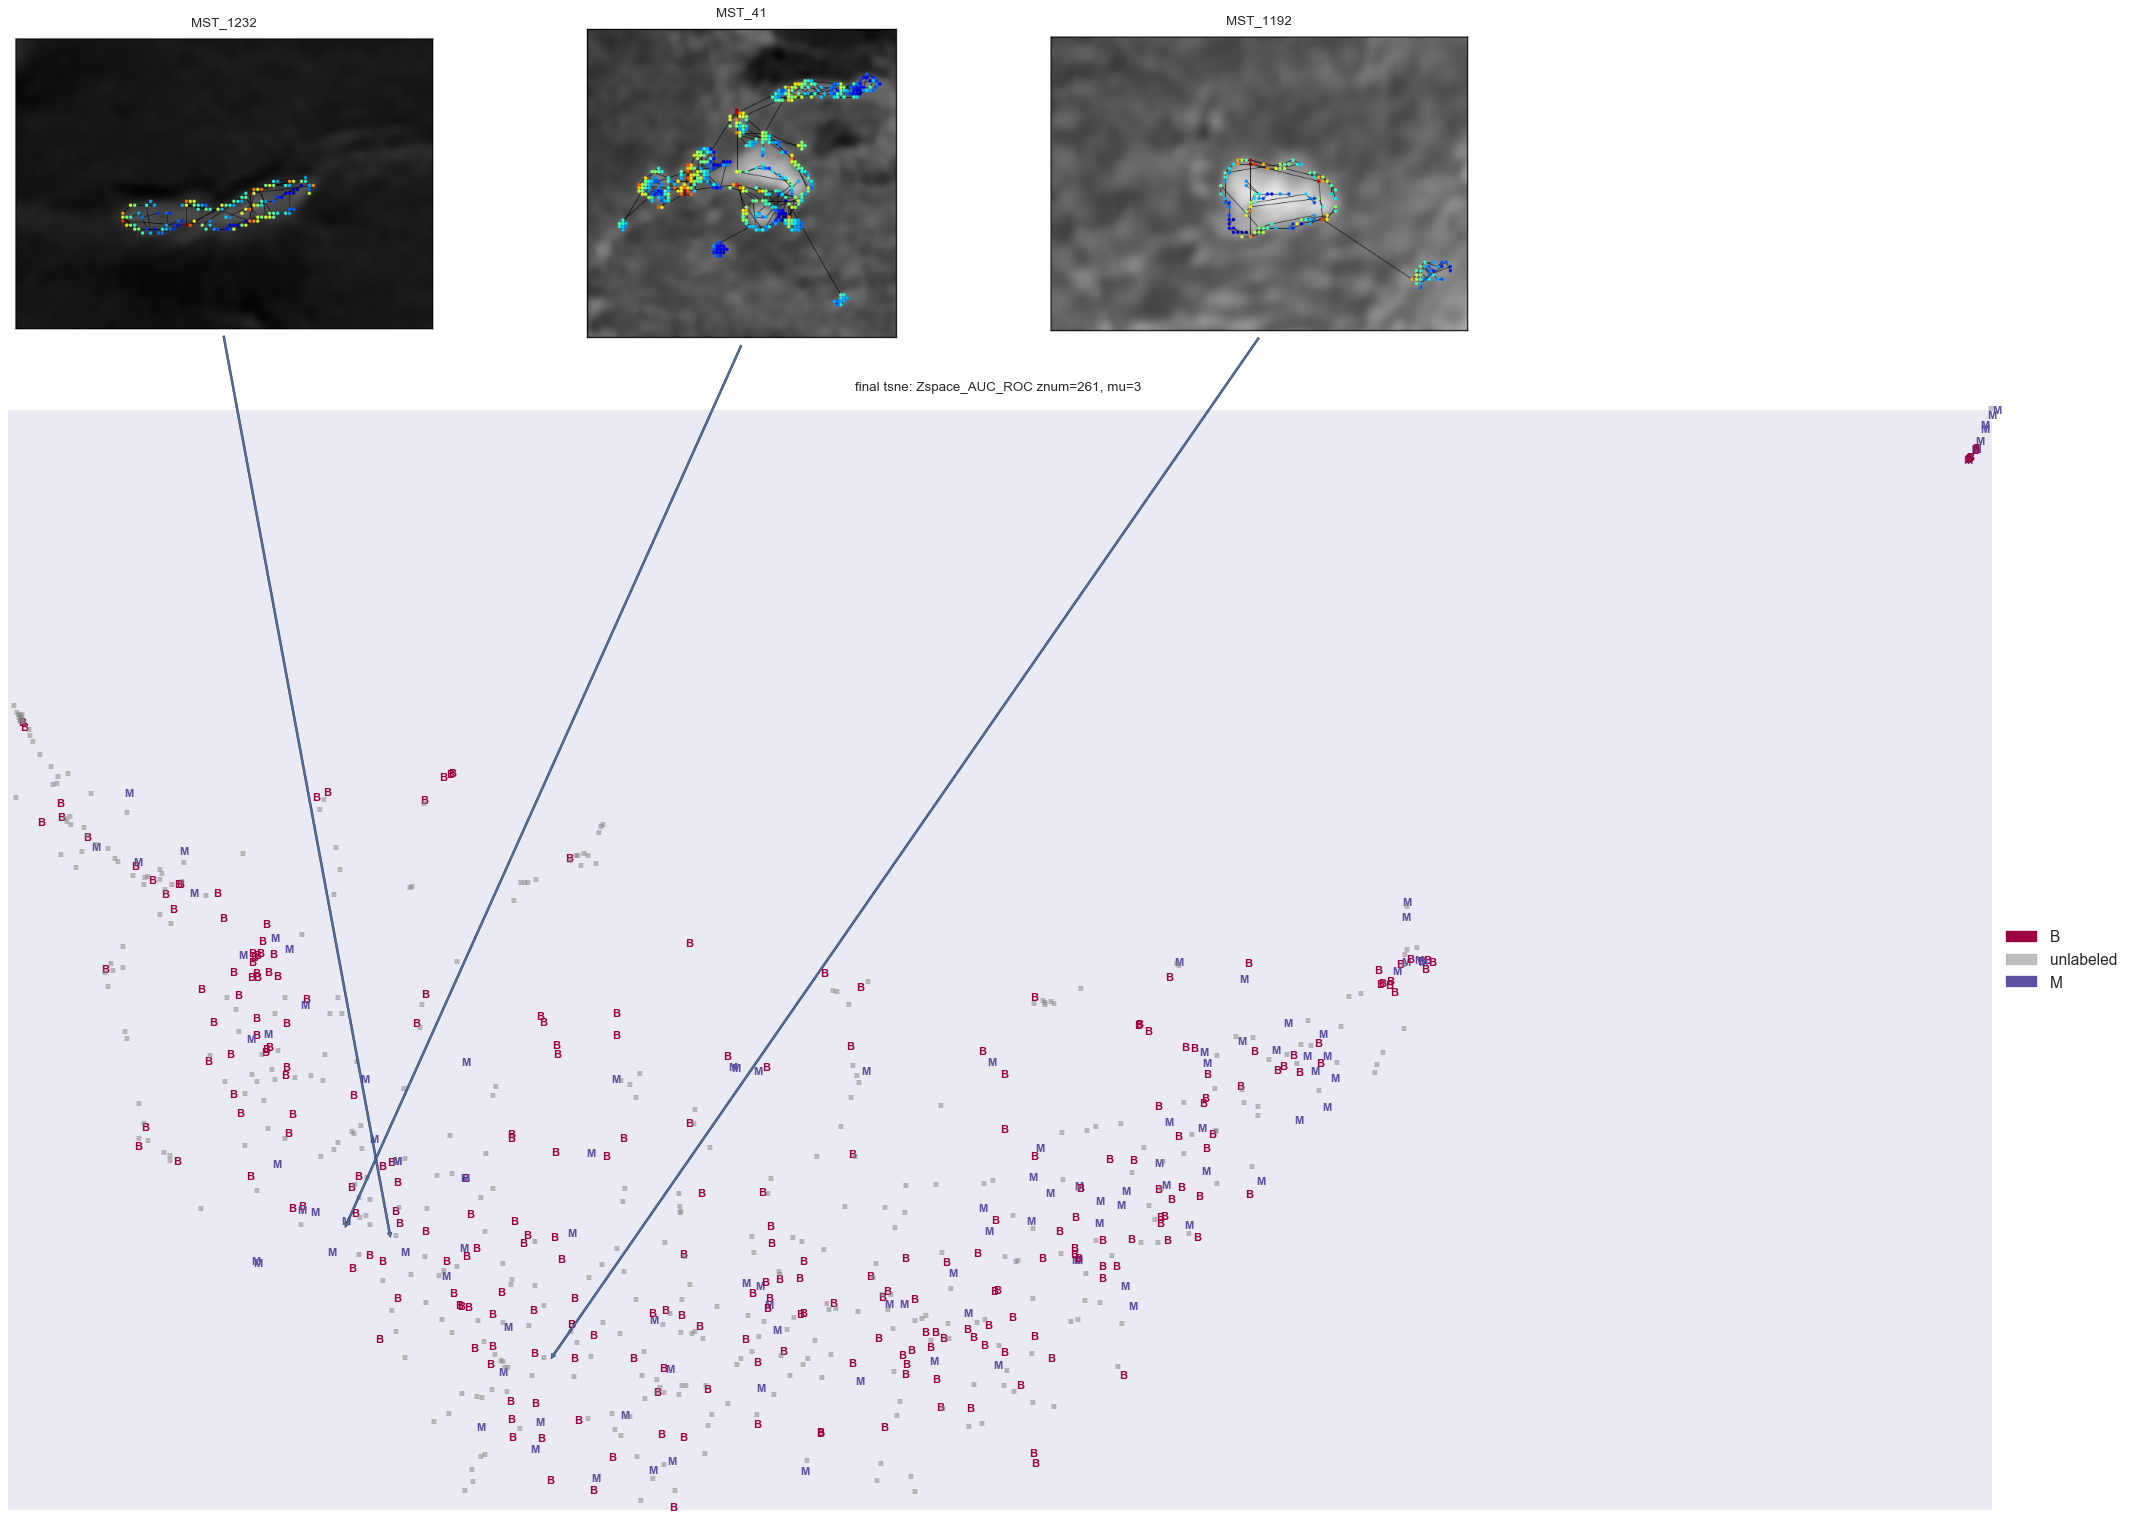

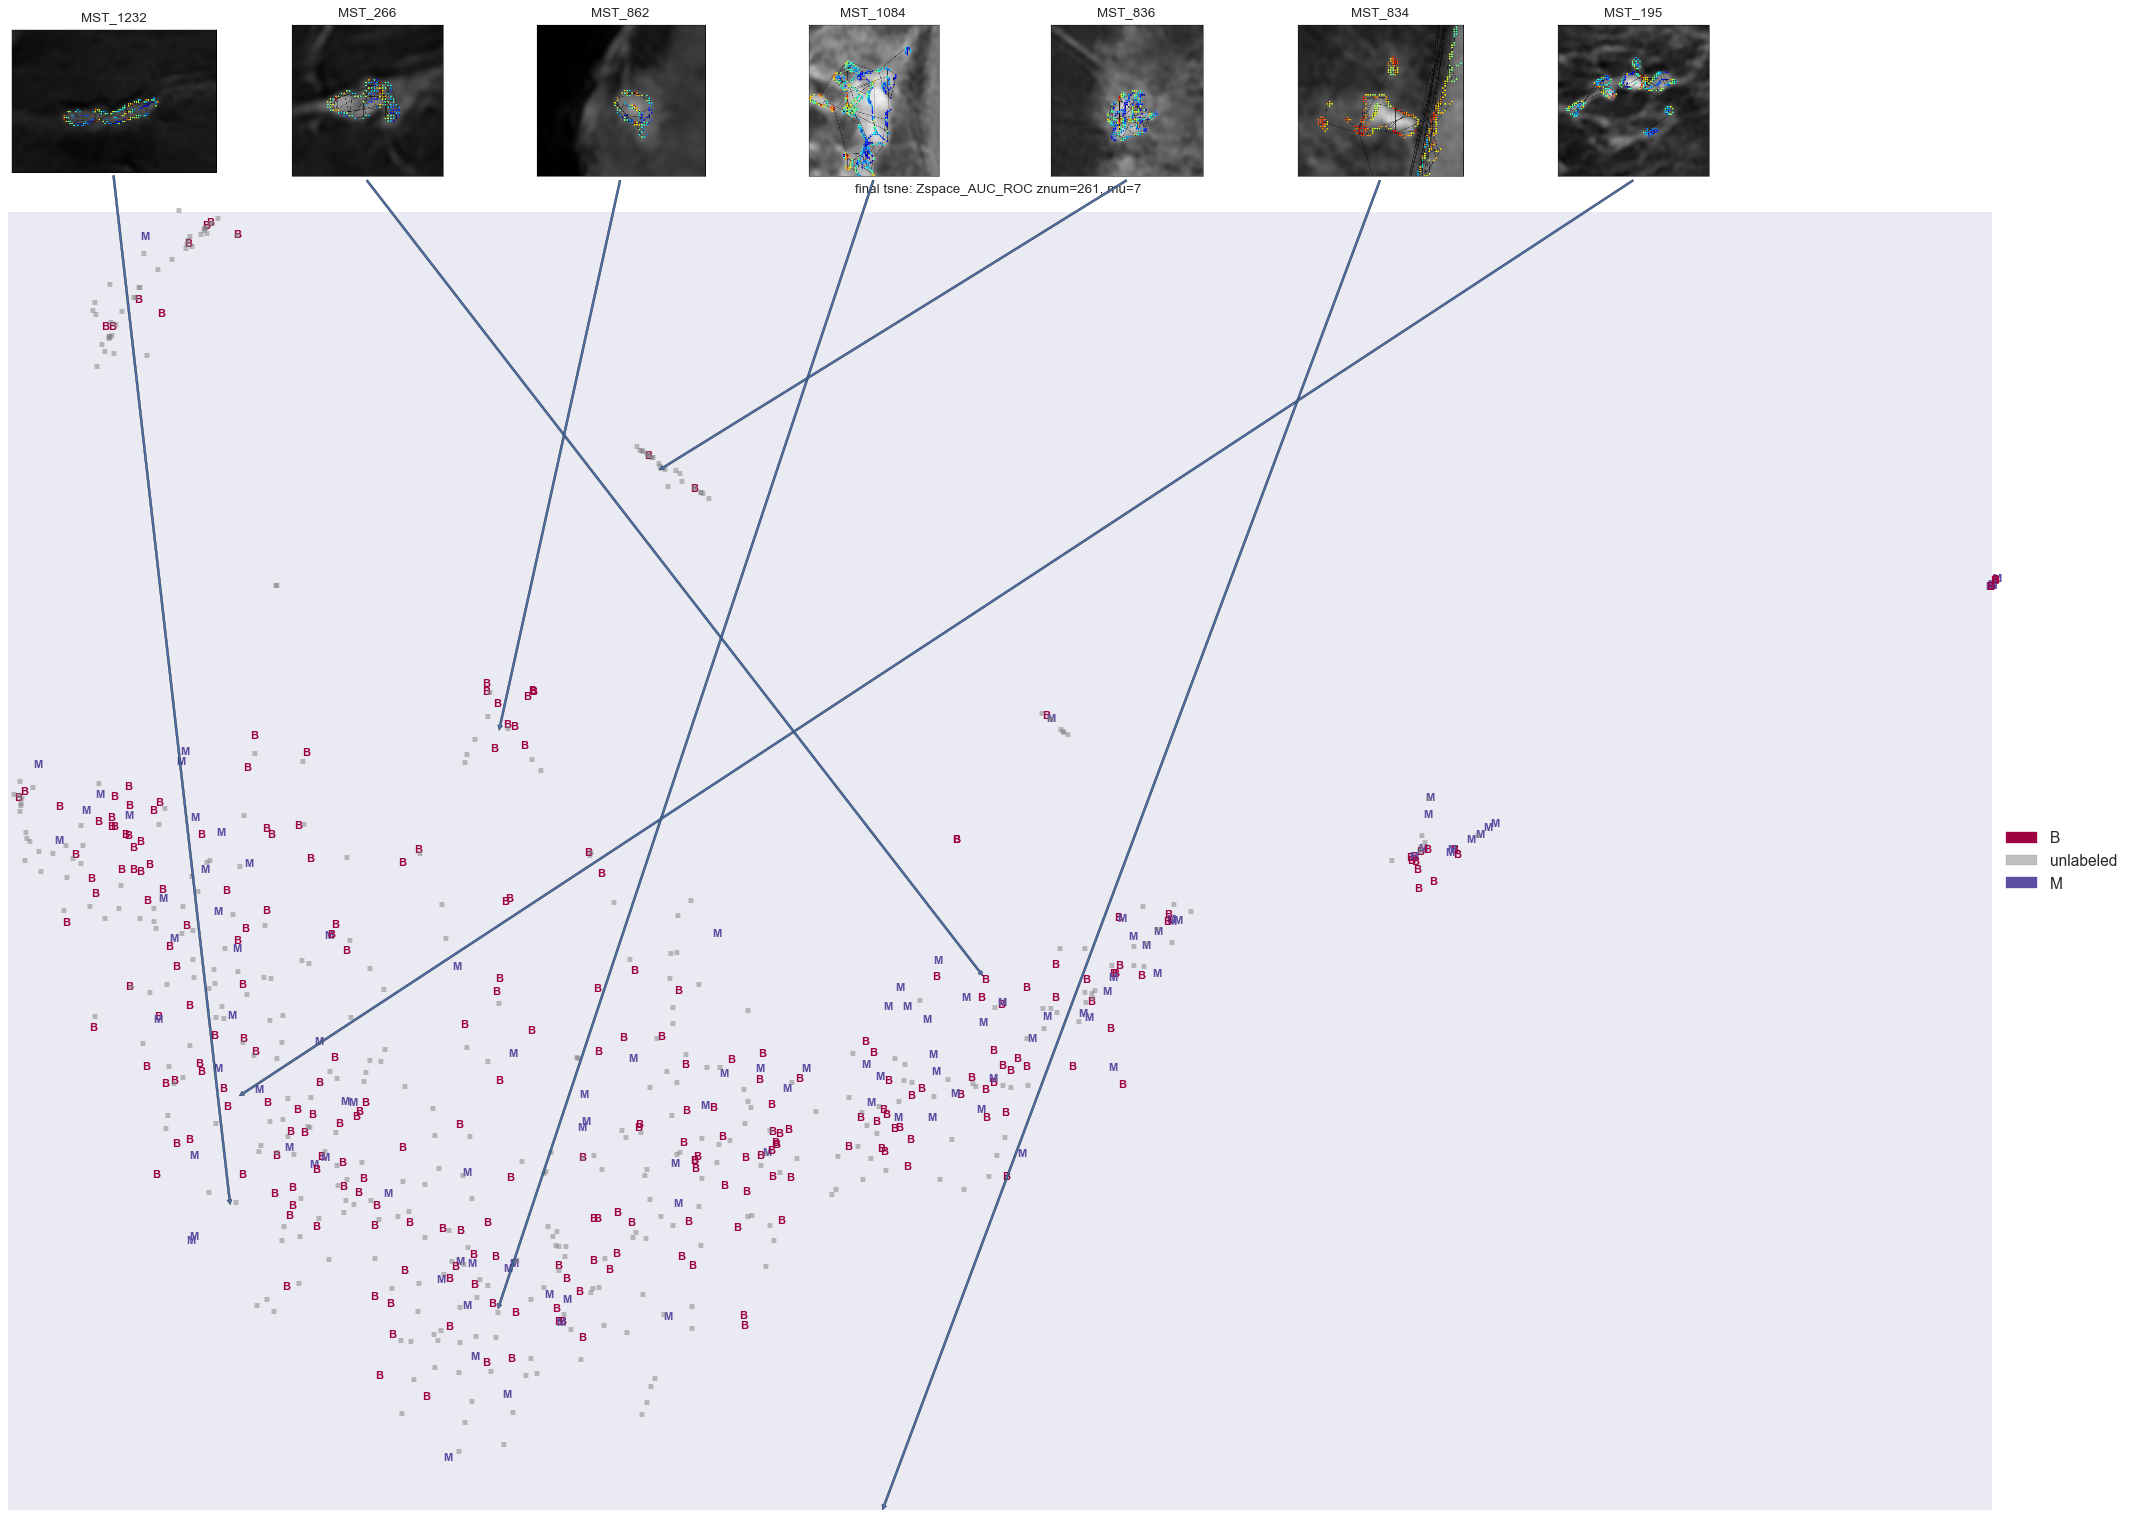

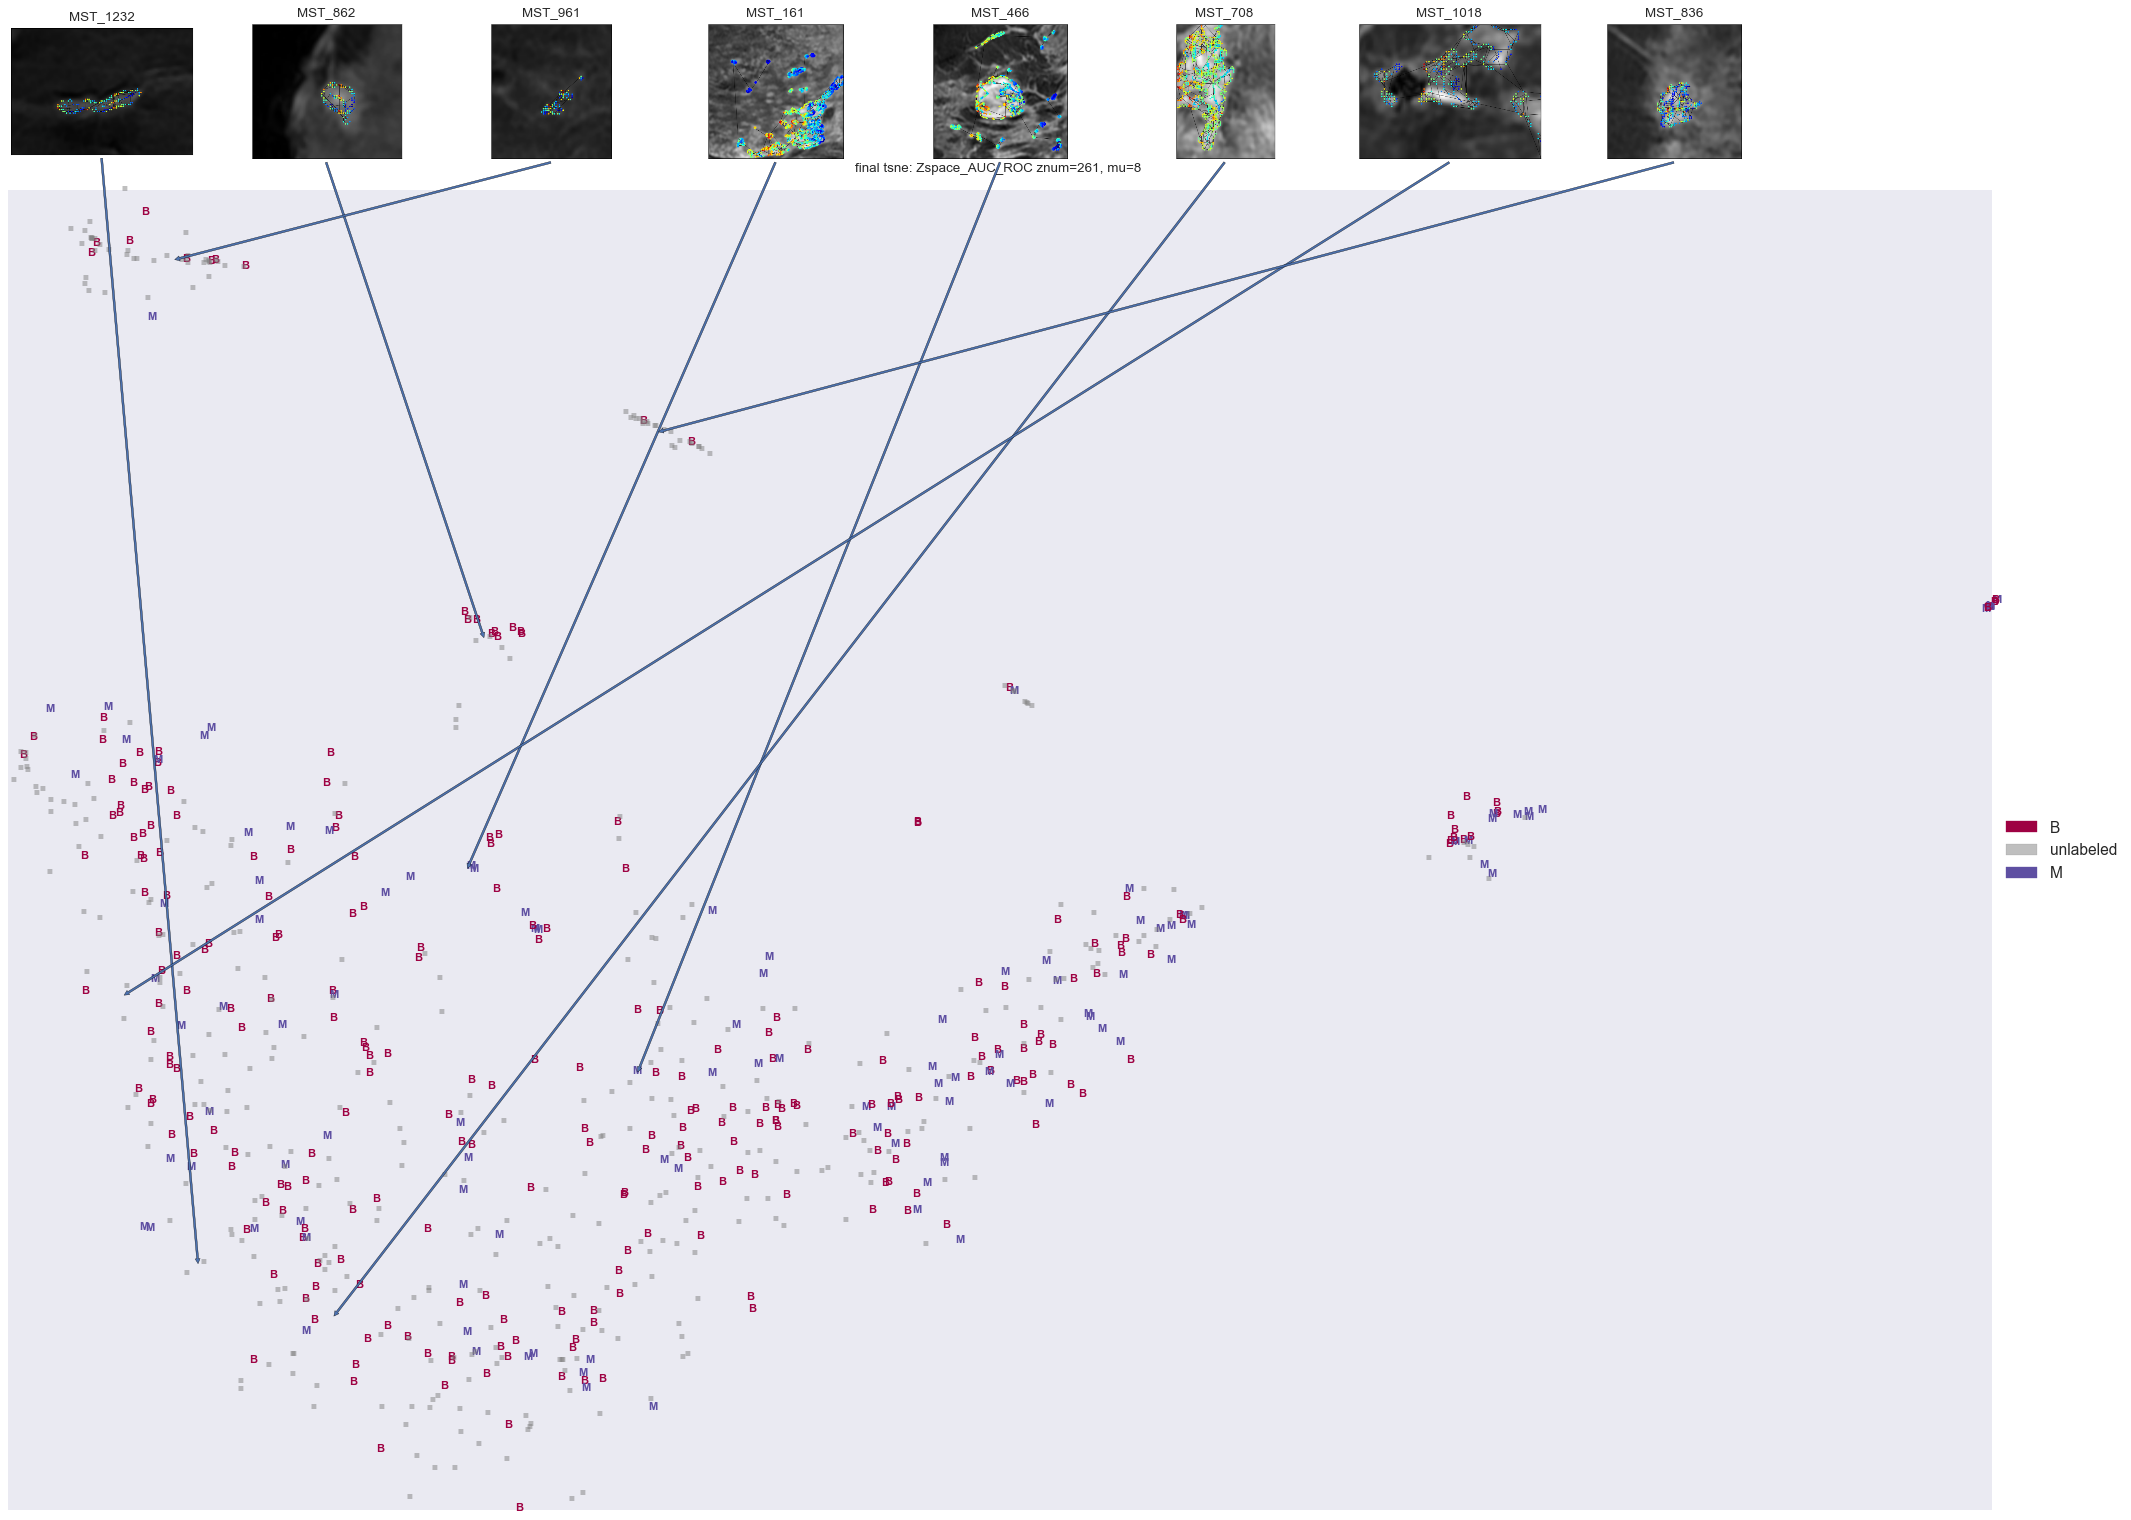

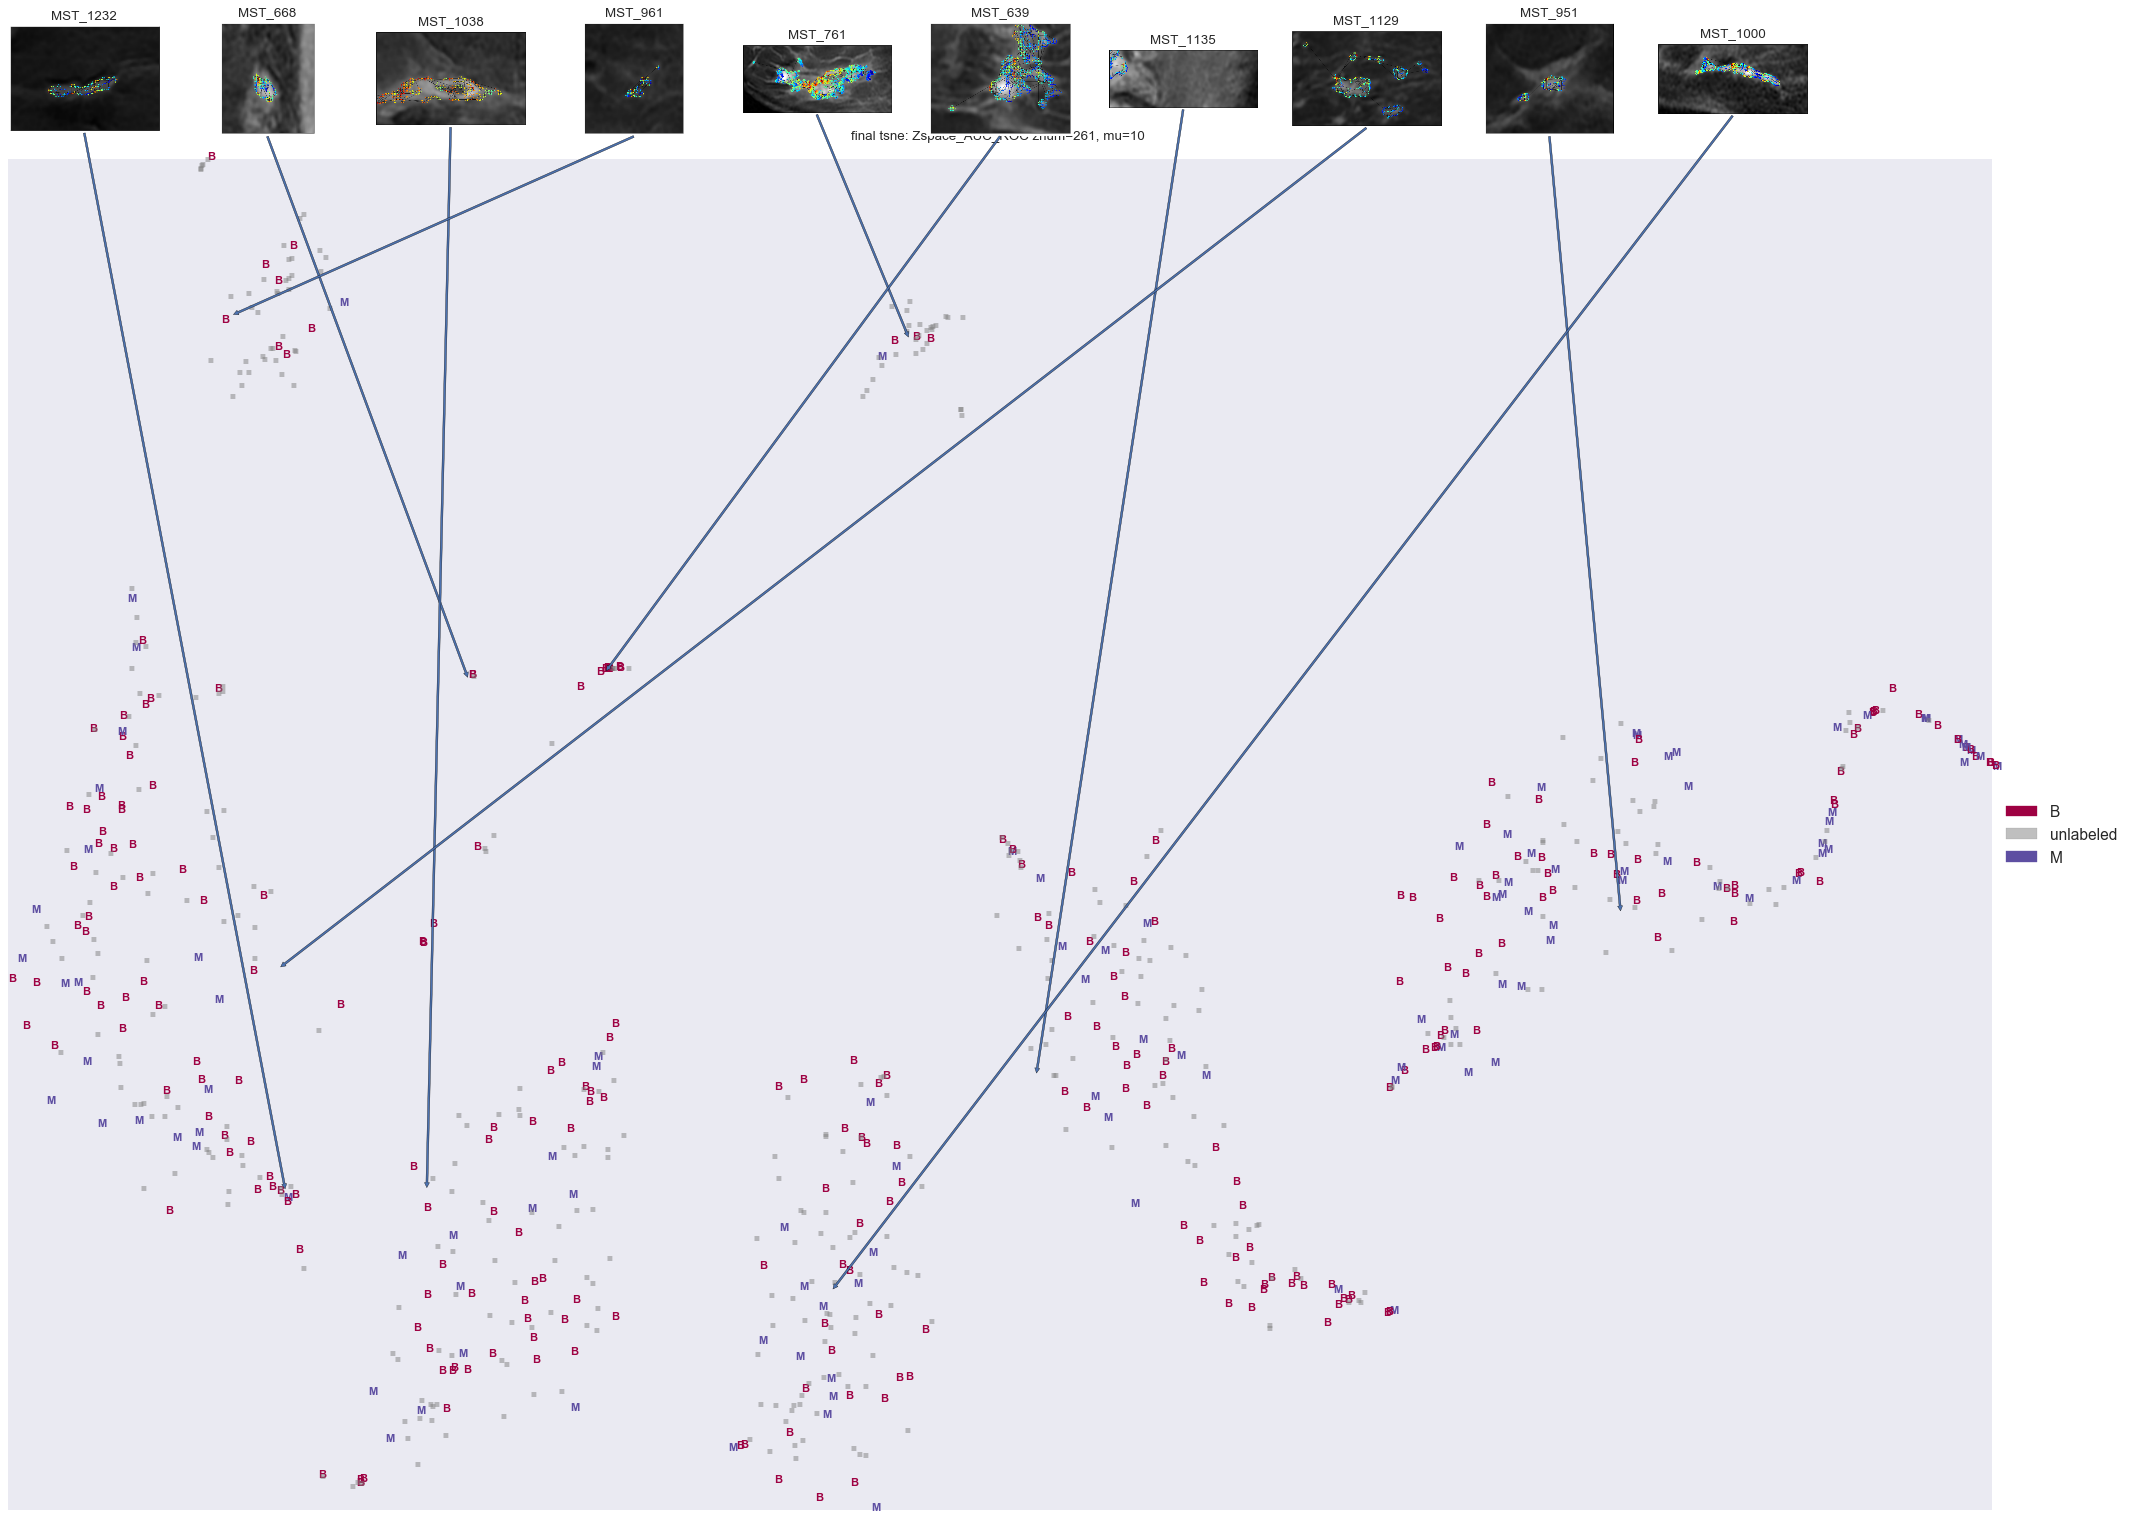

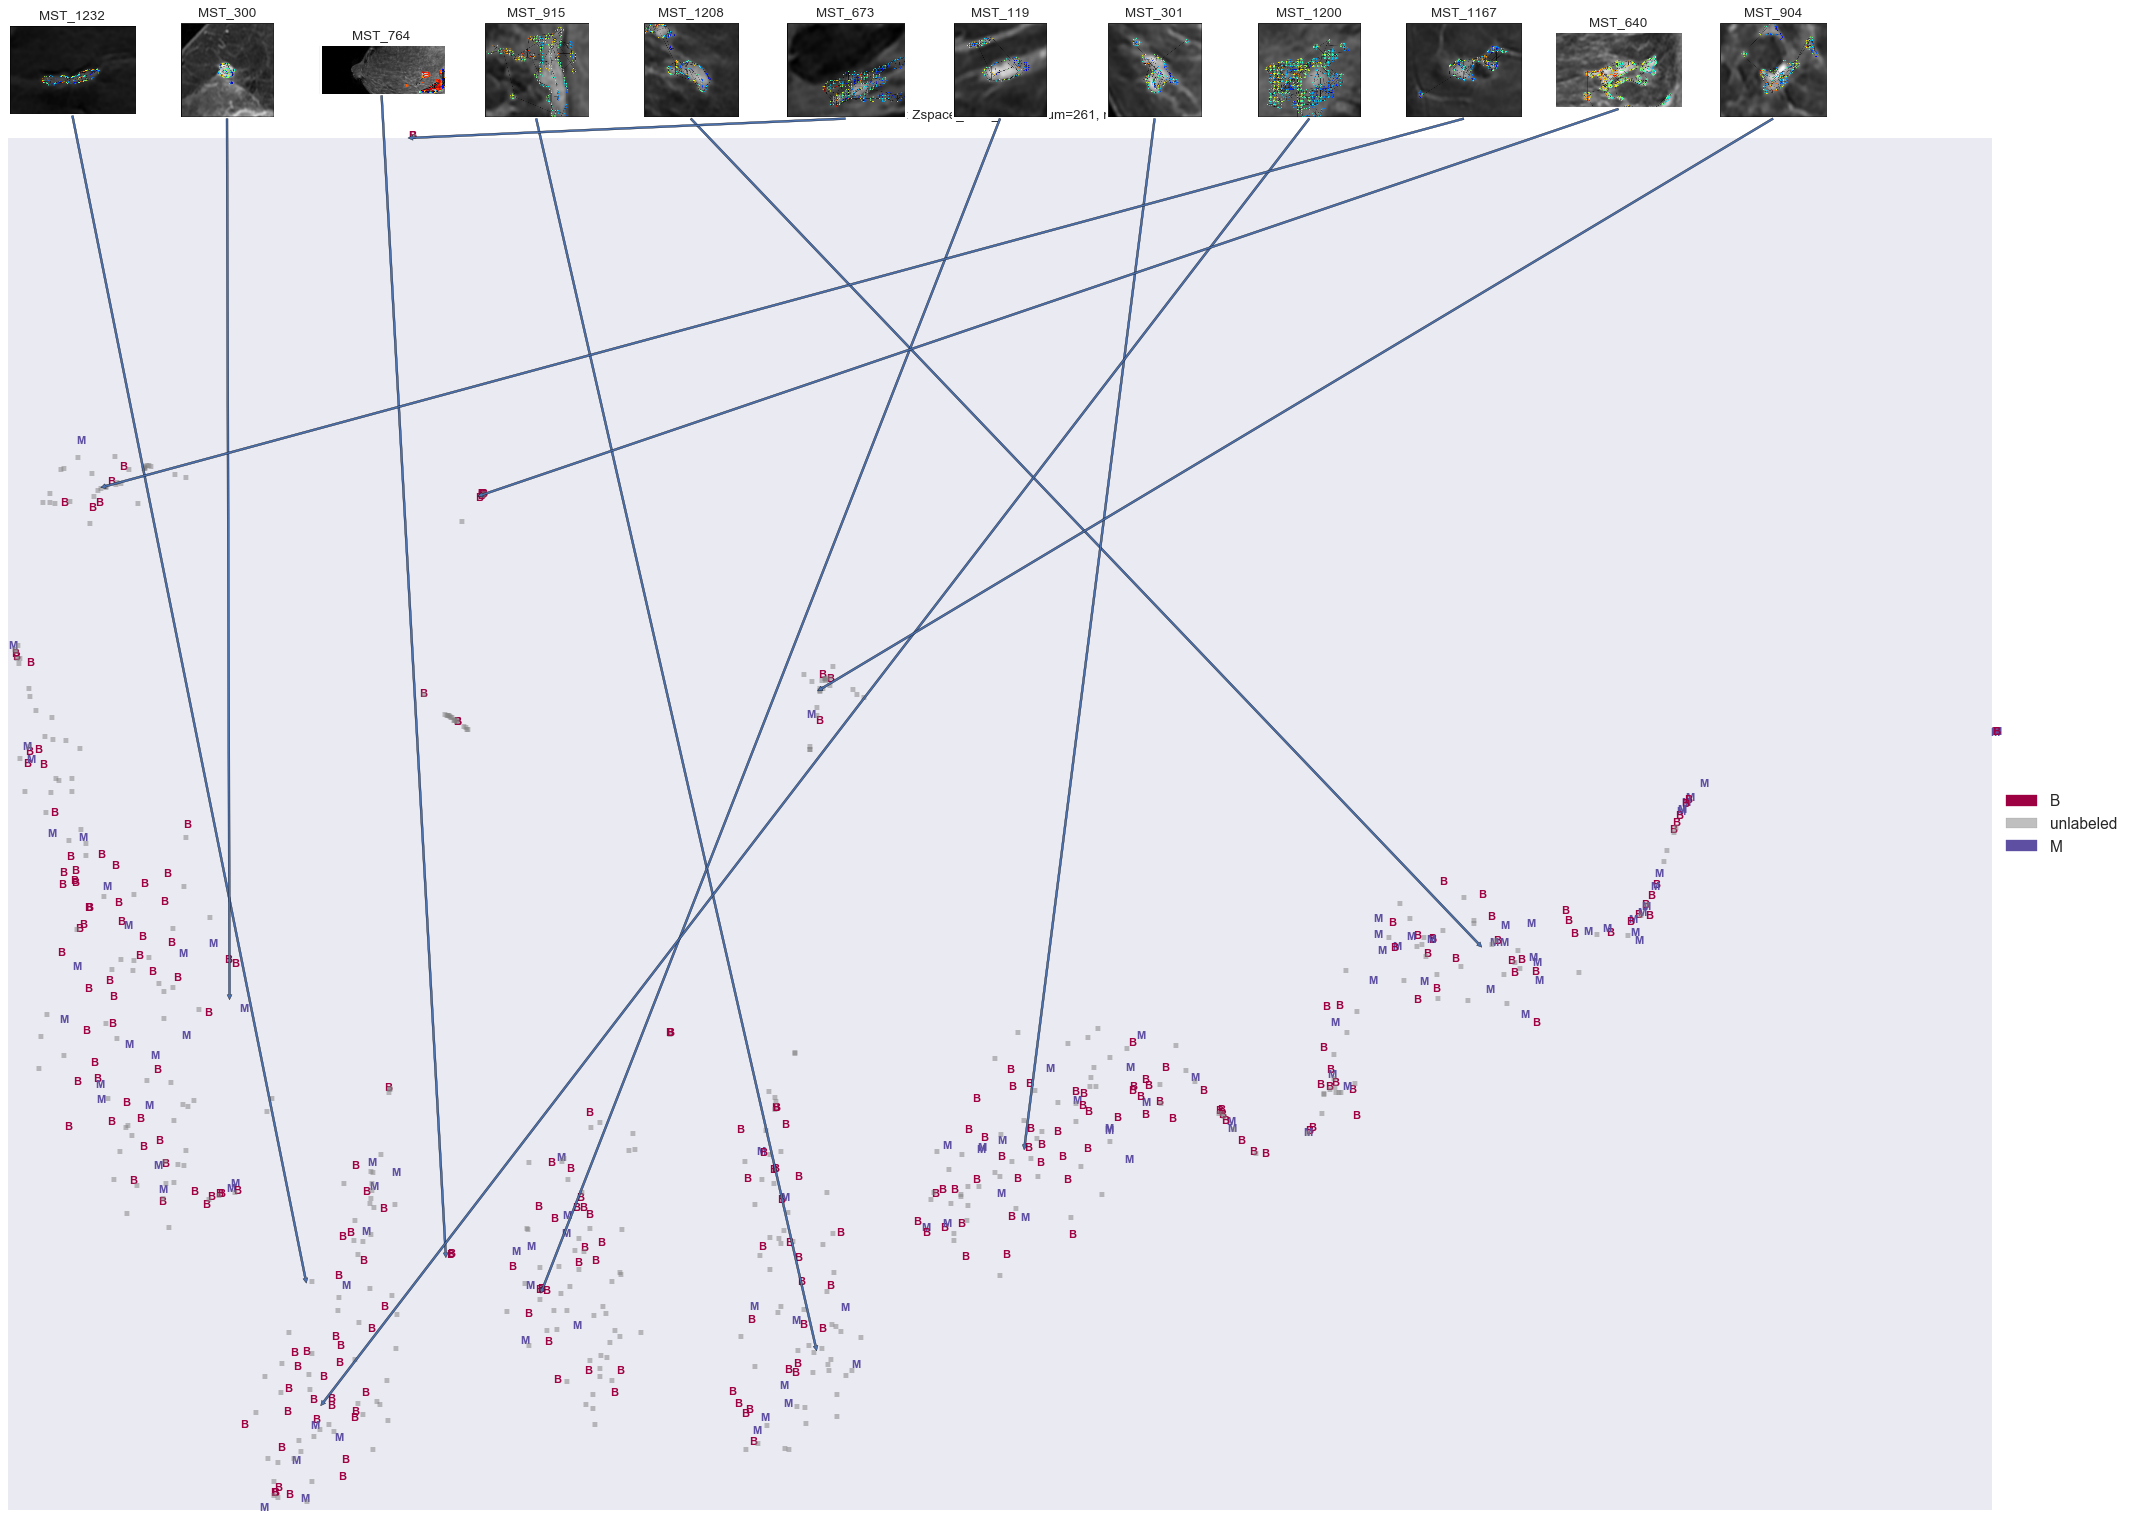

In [7]:
from decModel_wimgF_dualopt_descStats_NLLoss import *
labeltype = 'wimgF_dualopt_descStats_NLLoss' 
save_to = r'Z:\Cristina\Section3\NME_DEC\SAEmodels\decModel_wimgF_dualopt_descStats_NLLoss'
   
# to load a prevously DEC model  
input_size = combX_allNME.shape[1]
latent_size = [input_size/rxf for rxf in [2]]
varying_mu = [3,7,8,10,12] #[int(np.round(var_mu)) for var_mu in np.linspace(3,12,10]

######################
# DEC: define num_centers according to clustering variable
######################   
# to load a prevously DEC model  
for Zspacedim_best in latent_size:
    for num_clusters_best in varying_mu:

        print('Loading autoencoder of Zspacedim_best = {}, mu = {} , post training DEC results'.format(Zspacedim_best,num_clusters_best))
        
        with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(Zspacedim_best,num_clusters_best,labeltype)), 'rb') as fu:
            dec_model = pickle.load(fu)
          
        with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(Zspacedim_best,num_clusters_best,labeltype)), 'rb') as fu:
            outdict = pickle.load(fu)
            
        #####################
        # extract Z-space from optimal DEC model
        #####################
        # saved output results
        X = combX_allNME
        y = roi_labels
        
        dec_args_keys = ['encoder_1_bias', 'encoder_3_weight', 'encoder_0_weight', 
        'encoder_0_bias', 'encoder_2_weight', 'encoder_1_weight', 
        'encoder_3_bias', 'encoder_2_bias']
        dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
        dec_args['dec_mubestacci'] = dec_model['dec_mu']
        
        N = X.shape[0]
        all_iter = mx.io.NDArrayIter({'data': X}, 
                                     batch_size=X.shape[0],
                                     shuffle=False,
                                     last_batch_handle='pad')   
        ## extract embedded point zi 
        mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
        aDEC = DECModel(mx.cpu(), X, num_clusters_best, 1.0, Zspacedim_best, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 
        
        # organize weights and biases
        l1=[v.asnumpy().shape for k,v in aDEC.ae_model.args.iteritems()]
        k1=[k for k,v in aDEC.ae_model.args.iteritems()]
        l2=[v.asnumpy().shape for k,v in mxdec_args.iteritems()]
        k2=[k for k,v in mxdec_args.iteritems()]
        
        for ikparam,sizeparam in enumerate(l1):
            for jkparam,savedparam in enumerate(l2):
                if(sizeparam == savedparam):
                    #print('updating layer parameters: {}'.format(savedparam))
                    aDEC.ae_model.args[k1[ikparam]] = mxdec_args[k2[jkparam]]
        
        zbestacci = model.extract_feature(aDEC.feature, mxdec_args, None, all_iter, X.shape[0], aDEC.xpu).values()[0]      
        
        # compute model-based best-pbestacci or dec_model['pbestacci']
        pbestacci = np.zeros((zbestacci.shape[0], dec_model['num_centers']))
        aDEC.dec_op.forward([zbestacci, dec_args['dec_mubestacci'].asnumpy()], [pbestacci])
        #pbestacci = dec_model['pbestacci']
        
         # pool Z-space variables
        dataZspace_wmu = np.concatenate((zbestacci, pbestacci), axis=1) 
        # concatenating the cooordinates of the clusters as last points in array
        Zspace_mu = np.concatenate((dec_args['dec_mubestacci'].asnumpy(), np.eye(num_clusters_best,num_clusters_best)), axis=1) 
        dataZspace_wmu = np.concatenate((dataZspace_wmu, Zspace_mu), axis=0) 
                            
        tsne = TSNE(n_components=2, perplexity=15, learning_rate=125,
             init='pca', random_state=0, verbose=2, method='exact')
        Z_tsne = tsne.fit_transform(dataZspace_wmu)   
        y_tsne = y   
        # plot
        plot_embedding_unsuper_num_clusters(Z_tsne, y_tsne, num_clusters_best,
                                     title='final tsne: Zspace_AUC_ROC znum={}, mu={} \n'.format(Zspacedim_best,num_clusters_best), 
                                     legend=True, withClustersImg=True)

    